# Canny Edge Detector

## Compute the Image Gradient
### use Sobel filter to approximate the image gradient 

我们的图像是离散的，由一个个像素点组成，它不是一个连续的函数。我们无法像在微积分里那样，用求极限的方式来计算真正的导数。

所以，我们必须找到一种**近似**的方法。导数的基本定义是：
∂I/∂x ≈ [ I(x+h) - I(x) ] / h

在离散的图像中，我们能取的最小的 `h` 就是1个像素的距离。因此，最简单的近似方法就是**有限差分 (Finite Difference)**：

∂I/∂x ≈ I(x+1, y) - I(x-1, y)  *(这叫做中心差分，比 `I(x+1, y) - I(x, y)` 更精确)* 

**Sobel算子的高明之处在于，它在计算差分的同时，还加入了一个平滑（或加权平均）的步骤来抑制噪声。**

让我们来看一下Sobel的x方向卷积核 `Gx`：

```
-1  0  +1
-2  0  +2
-1  0  +1
```

这个卷积核可以分解为两个操作的组合：

1.  **x方向的中心差分**: 体现在每一行的 `[-1, 0, 1]` 结构上。
2.  **y方向的平滑**: 体现在列的 `[1, 2, 1]` 权重上。这实际上是一个简单的高斯平滑，它给予了中心像素更高的权重。

所以，当Sobel算子作用于一个像素时，它实际上是在计算**中心像素邻域内、经过y方向加权平均后、在x方向上的差值**。这比简单地用 `[-1, 0, 1]` 要鲁棒得多，因为它考虑了周围像素的影响，有效地降低了噪声。

同理，y方向的卷积核 `Gy`：
```
+1  +2  +1
 0   0   0
-1  -2  -1
```
就是在计算x方向平滑后的y方向差分。

### code

In [10]:
import numpy as np
def compute_gradient_magnitude_direction(x_grad, y_grad):
    """
        The function you need to implement for Q2 a).
        Inputs:
            x_grad: array(float) 
            y_grad: array(float)
        Outputs:
            magnitude_grad: array(float)
            direction_grad: array(float) you may keep the angle of the gradient at each pixel
    """
    magnitude_grad=np.sqrt(x_grad**2+y_grad**2)
    direction_grad=np.arctan2(y_grad,x_grad)
    
    return magnitude_grad, direction_grad 

## non_maximal_suppressor (非极大值抑制)

*   **目的**: 把模糊的、粗大的边缘变得清晰、纤细（只有一个像素宽）。
*   **怎么做**:
    1.  **量化方向**: 我们不需要精确到360°的每一个角度，只需要知道梯度是大致朝向“水平”、“垂直”，还是两个“对角线”方向就够了。代码里把 `[-180, 180]` 度的角度分成了4个区域。
    2.  **邻里比较**: 遍历每个像素，看看它的梯度方向属于哪个区域。
        *   如果是“水平”方向，就跟它左边和右边的邻居比梯度大小。
        *   如果是“垂直”方向，就跟它上边和下边的邻居比。
        *   如果是“对角线”方向，就跟对角线上的邻居比。
    3.  **优胜劣汰**: 只有当这个像素的梯度大小**大于等于**它在该方向上的两个邻居时，它才被认为是真正的边缘峰值点，我们才在 `NMS_output` 中保留它的值。否则，它就被“抑制”了，值变为0。

### code

In [11]:
def non_maximal_suppressor(grad_mag, grad_dir):
    """
    非极大值抑制的向量化实现，无 for 循环。
    Inputs:
        grad_mag: 梯度大小 (float类型的数组)
        grad_dir: 梯度方向 (float类型的数组)
    Outputs:
        NMS_output: 经过非极大值抑制后的图像 (float类型的数组)
    """
    h, w = grad_mag.shape
    # 输出图像先初始化为0
    NMS_output = np.zeros((h, w), dtype=np.float32)
    
    # 将梯度方向从弧度 [-pi, pi] 转换为角度 [0, 180]，180.的.是为了确保转化成浮点数
    # angles < 0 会生成一个与 angles 形状相同的布尔数组，其中每个元素表示对应位置的值是否小于 0。
    # angles[angles < 0] 会选取 angles 中所有小于 0 的元素。
    # += 180 会将这些选中的元素都加上 180。
    angles = grad_dir * 180. / np.pi
    angles[angles < 0] += 180

    # --- 步骤 1: 创建四个方向的布尔掩码 ---
    # 方向 1: 水平 (0°)
    mask1 = ( (0 <= angles) & (angles < 22.5) ) | ( (157.5 <= angles) & (angles <= 180) )
    # 方向 2: 右上/左下对角线 (45°)
    mask2 = (22.5 <= angles) & (angles < 67.5)
    # 方向 3: 垂直 (90°)
    mask3 = (67.5 <= angles) & (angles < 112.5)
    # 方向 4: 左上/右下对角线 (135°)
    mask4 = (112.5 <= angles) & (angles < 157.5)

    # --- 步骤 2: 使用 np.roll 获取所有邻居的值，创建“邻居图” ---
    # np.roll(arr, shift, axis) 可以滚动数组。
    # 例如，axis=1 (水平), shift=1 会把最左边一列滚到最右边，实现所有像素的“左邻居”图。
    left_neighbor = np.roll(grad_mag, 1, axis=1)
    right_neighbor = np.roll(grad_mag, -1, axis=1)
    up_neighbor = np.roll(grad_mag, 1, axis=0)
    down_neighbor = np.roll(grad_mag, -1, axis=0)
    up_left_neighbor = np.roll(up_neighbor, 1, axis=1)
    up_right_neighbor = np.roll(up_neighbor, -1, axis=1)
    down_left_neighbor = np.roll(down_neighbor, 1, axis=1)
    down_right_neighbor = np.roll(down_neighbor, -1, axis=1)

    # --- 步骤 3: 分别处理每个方向的像素 ---
    # 对于方向1 (水平) 的像素，只有当它的值 >= 左邻居 AND >= 右邻居时，才保留
    horizontal_pixels = np.where(mask1 & (grad_mag >= left_neighbor) & (grad_mag >= right_neighbor), grad_mag, 0)
    
    # 对于方向2 (45°) 的像素...
    diag45_pixels = np.where(mask2 & (grad_mag >= up_right_neighbor) & (grad_mag >= down_left_neighbor), grad_mag, 0)
    
    # 对于方向3 (垂直) 的像素...
    vertical_pixels = np.where(mask3 & (grad_mag >= up_neighbor) & (grad_mag >= down_neighbor), grad_mag, 0)

    # 对于方向4 (135°) 的像素...
    diag135_pixels = np.where(mask4 & (grad_mag >= up_left_neighbor) & (grad_mag >= down_right_neighbor), grad_mag, 0)

    # --- 最后，将四个方向处理完的结果合并起来 ---
    NMS_output = horizontal_pixels + diag45_pixels + vertical_pixels + diag135_pixels
    
    # 注意：np.roll 会导致边界环绕（wrap-around），例如最左边像素的左邻居是
    # 最右边的像素。这在大多数情况下是可接受的简化，并避免了处理边界的复杂逻辑。
    
    return NMS_output

#### np.roll(a, shift, axis=None)
- `a`：输入数组。
- `shift`：滚动的位数。
  - 正数：向**后**滚动（在指定轴上，元素往索引增大的方向移动）。
  - 负数：向**前**滚动（元素往索引减小的方向移动）。
- `axis`：沿哪个轴滚动。
  - `axis=0`：沿行方向（垂直方向）滚动（即整行上下移动）。
  - `axis=1`：沿列方向（水平方向）滚动（即整列左右移动）。
  - 如果不指定 `axis`，数组会被展平后滚动，再恢复形状（一般不这么用）。

---

**🔍 举个简单例子：**

1. 1D
```python
import numpy as np
arr = np.array([1, 2, 3, 4, 5])

print(np.roll(arr, 1))   # [5, 1, 2, 3, 4]  ← 最后一个元素滚到开头
print(np.roll(arr, -1))  # [2, 3, 4, 5, 1]  ← 第一个元素滚到末尾
```

2. 2D 图像中的滚动

假设我们有一个 3×3 的图像（或梯度幅值图）：
```python
grad_mag = np.array([[10, 20, 30],
                     [40, 50, 60],
                     [70, 80, 90]])
```

`np.roll(grad_mag, 1, axis=1)` → **“右移”得到左邻居！**
- `axis=1`：按**列**滚动（水平方向）。
- `shift=1`：每个元素**向右移动 1 位**，最右边的列滚到最左边。

结果：
```python
[[30, 10, 20],
 [60, 40, 50],
 [90, 70, 80]]
```


#### np.where
`np.where` 有两种主要用法：

**✅ 用法 1：三元选择（最常用）**
```python
np.where(condition, x, y)
```
- **功能**：对数组中每个位置，如果 `condition` 为 `True`，就选 `x` 对应位置的值；否则选 `y` 对应位置的值。
- **要求**：`condition`、`x`、`y` 的形状要能广播（broadcast）兼容（通常三者形状相同）。
- **返回**：一个与输入形状相同的数组。

**✅ 用法 2：仅传入 condition（返回索引）**
```python
np.where(condition)
```
- **功能**：返回满足 `condition` 为 `True` 的**索引位置**（以元组形式）。
- 常用于找出符合条件的坐标。


## hysteresis_thresholding

### 核心思想：模拟“火势蔓延”

想象一下，我们的 NMS 结果图是一片森林：
*   **强边缘 (Strong Edges)**：是已经着火的树木。
*   **弱边缘 (Weak Edges)**：是易燃的、但还没被点燃的树木。
*   **其他像素**：是不可燃的石头。

我们的目标是找出所有最终会被点燃的树木。火势蔓延的规则是：**如果一棵易燃的树（弱边缘）旁边有一棵正在燃烧的树（强边缘），那么它也会被点燃。** 这个过程会形成一条“火龙”，不断蔓延，直到周围再也没有易燃的树为止。
### 向量化策略分解：

1.  **初始分类**：和之前一样，我们首先用布尔掩码一次性找出所有的“强边缘”和“弱边缘”的位置。
2.  **模拟一步蔓延**：
    *   我们创建一个代表“当前火场”（即所有强边缘）的二值图。
    *   我们用一个 3x3 的全1卷积核 `[[1,1,1], [1,1,1], [1,1,1]]` 对这个“火场图”进行卷积。
    *   卷积的结果图中，所有**值大于0**的位置，就代表它们是“火场”的邻居。
3.  **点燃新树木**：我们将这些“火场邻居”的位置，与“易燃树木”（弱边缘）的位置取交集。这个交集里的点，就是新被点燃的树木。
4.  **重复直到稳定**：我们将这些新点燃的树木加入“火场”，然后重复第2步和第3步。这个过程不断进行，直到某一步再也没有新的树木被点燃为止。这时，火势稳定了，我们就找到了所有与初始强边缘相连的边缘。


### code

In [ ]:
from scipy.signal import convolve2d 
import numpy as np

def hysteresis_thresholding(img):
    """
    使用双阈值法进行边缘连接 (完全向量化的无循环版本)。
    Inputs:
        img: 经过非极大值抑制后的图像 (float类型的数组)
    Outputs:
        output: 最终的二值化边缘图 (float类型的数组, 像素值为0或1)
    """
    # 根据作业指导，设定高低阈值比例
    low_ratio = 0.10
    high_ratio = 0.30

    high_threshold = img.max() * high_ratio
    low_threshold = high_threshold * low_ratio

    # --- 步骤 1: 初始分类，找出强、弱边缘 ---
    # 使用布尔掩码，效率极高
    strong_edges = (img >= high_threshold)
    weak_edges = (img >= low_threshold) & (img < high_threshold)

    # --- 步骤 2: 模拟“火势蔓延”的链式反应 ---
    # `output_img` 初始化为所有确定的强边缘
    output_img = np.copy(strong_edges)
    
    # 定义一个3x3的卷积核，用于寻找8邻域
    kernel = np.ones((3, 3), dtype=bool)

    # 这个循环模拟蔓延的轮次，直到没有新的弱边缘被“点燃”
    while True:
        # 记录上一轮的边缘数量
        old_sum = np.sum(output_img)
        
        # 使用卷积找到当前所有边缘点的8邻域
        # mode='same' 保证输出和输入大小一致
        neighbors_of_strong_edges = convolve2d(output_img, kernel, mode='same').astype(bool)
        
        # 找出那些“是弱边缘” AND “是强边缘邻居”的点
        # 这些点是本轮新被“点燃”的
        newly_lit_edges = neighbors_of_strong_edges & weak_edges
        
        # 将新点燃的边缘加入到最终输出中
        output_img = output_img | newly_lit_edges
        
        # 检查本轮是否有新的边缘被点燃
        new_sum = np.sum(output_img)
        if new_sum == old_sum:
            # 如果数量没有变化，说明“火势”已经稳定，可以结束循环
            break
            
    # 将布尔图转换为float类型 (0.0 或 1.0)
    return output_img.astype(float)

## Outcome
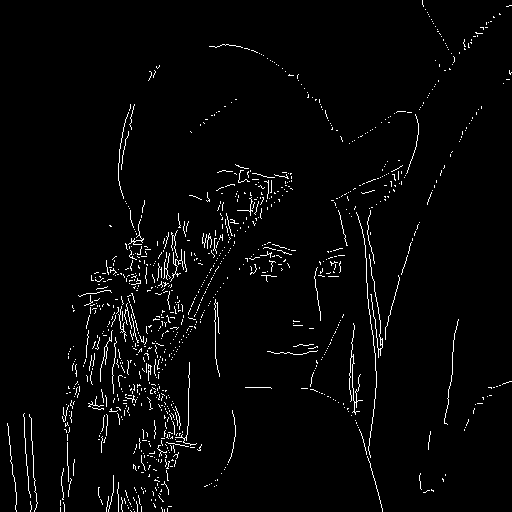